In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
import datetime
import seaborn as sns

In [2]:
import dwave
from dwave.cloud import Client
client = Client.from_config(config_file= '/home/rajarsi/.config/dwave/dwave.conf' )
dwave.cloud.config.load_config(['/home/rajarsi/.config/dwave/dwave.conf'])
import dimod
import neal
from dwave.system import LeapHybridCQMSampler, DWaveSampler , LeapHybridSampler
from dimod import BinaryQuadraticModel as BQM
from dimod import QuadraticModel as QM
from dimod import ConstrainedQuadraticModel as CQM


#### Scratch 

In [3]:
## define bqm ~
bqm = BQM({'x':2, 'y':-1,'z':1},{ ('x','y'):-1, ('x','z'): -2, ('y','z'): 1}, 0 , 'SPIN')
bqm


BinaryQuadraticModel({'x': 2.0, 'y': -1.0, 'z': 1.0}, {('y', 'x'): -1.0, ('z', 'x'): -2.0, ('z', 'y'): 1.0}, 0.0, 'SPIN')

In [4]:
## convert to CQM and add constraints ~
cqm = CQM.from_bqm(bqm)
cqm.add_constraint_from_iterable([('x','z',2), ('x',1), ('y', -1), ('y','z', 1) ], '<=', rhs= 3 , label= 'c1')
cqm.constraints['c1'].to_polystring()
# cqm.objective

'x - y + 2*x*z + z*y <= 3'

In [5]:
## setup sampler 
sampler = LeapHybridSampler()
# smpl_set = sampler.sample(bqm)

In [6]:
# print(smpl_set)

### Example: Portfolio Optmisation

##### Getting Stock Data

In [7]:
def get_stock_data(stocks, start= datetime.datetime(2000,1,1) , end= datetime.datetime(2022,1,1) ) :
    """ Return stock data and covariace matrix corresponding to it """
    data = pd.DataFrame()
    for stock in stocks:
         data[stock] = pdr.DataReader(stock,data_source='yahoo', start= start, end= end)['Adj Close']

    rtrn_data = data/data.shift(1)
    rtrn_data =  np.log(rtrn_data[1:])
    cov_matrix = rtrn_data.cov()
    return rtrn_data, cov_matrix

In [8]:
stocks= ['FB', 'MSFT', 'AAPL', 'IBM', 'GOOGL', 'TSLA', 'AMZN', 'JPC']
data = get_stock_data(stocks)


In [9]:
cov_matrix = data[1]
mean_rtrn = data[0].mean()
for stock in stocks : cov_matrix[stock][stock] = 0

<AxesSubplot:>

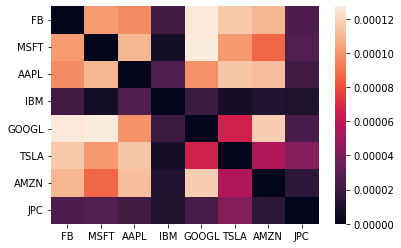

In [10]:
sns.heatmap(cov_matrix)

##### Setting up BQM

In [11]:
bqm = BQM('BINARY')
for stock in stocks : bqm.add_variable(stock)

## prepare quadratic model corresponding to portfolio 
for stock in stocks: bqm.add_linear_from({stock: -1*mean_rtrn[stock]})
for stock_i in stocks :
    for stock_j in stocks : 
        if stock_i != stock_j: bqm.add_quadratic_from({(stock_i, stock_j): +1*cov_matrix[stock_i][stock_j] })
        
# bqm

##### Simulated Annealing solver

In [12]:
sampler = neal.SimulatedAnnealingSampler()
# sampler.properties, sampler.parameters

In [13]:
pf_op = sampler.sample(bqm, num_sweeps= 100, num_sweeps_per_beta= 50, num_reads= 10 ,beta_schedule= 'geometric' ,seed= 1234)

In [14]:
## most optimal solution 
pf_op.first


Sample(sample={'AAPL': 1, 'AMZN': 0, 'FB': 0, 'GOOGL': 1, 'IBM': 1, 'JPC': 0, 'MSFT': 1, 'TSLA': 1}, energy=-0.006958431103377519, num_occurrences=1)

##### Setting up QM

In [28]:
dimod.REAL_INTERACTIONS = True

In [29]:
qm = QM()
for stock in stocks : qm.add_variable('REAL',stock)

## prepare quadratic model corresponding to portfolio 
for stock in stocks: qm.add_linear_from({stock: -1*mean_rtrn[stock]})
for stock_i in stocks :
    for stock_j in stocks : 
        if stock_i != stock_j: qm.add_quadratic_from({(stock_i, stock_j): +1*cov_matrix[stock_i][stock_j] })
        

##### Setting up CQM

In [40]:
cqm = CQM.from_qm(qm)
# cqm.objective
vars = cqm.variables

In [41]:
vars =  [dimod.Real(var) for var in vars ]


In [42]:
cqm.add_constraint(sum(vars) <= len(vars), label= 'stock constraint')

'stock constraint'

In [44]:
cqm.constraints

{'stock constraint': Le(QuadraticModel({'FB': 1.0, 'MSFT': 1.0, 'AAPL': 1.0, 'IBM': 1.0, 'GOOGL': 1.0, 'TSLA': 1.0, 'AMZN': 1.0, 'JPC': 1.0}, {}, 0.0, {'FB': 'REAL', 'MSFT': 'REAL', 'AAPL': 'REAL', 'IBM': 'REAL', 'GOOGL': 'REAL', 'TSLA': 'REAL', 'AMZN': 'REAL', 'JPC': 'REAL'}, dtype='float64'), 8)}

In [50]:
sample_set_leap_real = sampler_cqm.sample_cqm(cqm)

In [51]:
sample_set_leap_real.first

SolverFailureError: The number of quadratic real variables must not exceed 0.

##### Using ExactSolver 

In [48]:
from dimod import ExactCQMSolver
sample_set = ExactCQMSolver().sample_cqm(cqm)

ValueError: Only Binary, Spin, or Integer variables supported by ExactCQMSolver

In [18]:
sample_set.first

Sample(sample={'AAPL': 1, 'AMZN': 0, 'FB': 0, 'GOOGL': 1, 'IBM': 1, 'JPC': 0, 'MSFT': 1, 'TSLA': 1}, energy=-0.006958431103377518, num_occurrences=1, is_satisfied=array([ True]), is_feasible=True)

##### Using Leap's sampler

In [49]:
sampler_cqm = LeapHybridCQMSampler()
# sample_set_leap = sampler_cqm.sample_cqm(cqm)

In [20]:
# sample_set_leap.first

##### Using 'REAL' vartype in CQM

In [21]:
cqm = CQM()

In [22]:
for stock in stocks: cqm.add_variable('REAL', stock)

In [23]:
cqm.set_objective('FB'+ 0.3*'IBM')

TypeError: can't multiply sequence by non-int of type 'float'

In [ ]:
vars_real =  [dimod.Real(var) for var in cqm.variables ]
cqm.add_constraint(sum(vars_real) <= len(vars), label= 'stock constraint')

'stock constraint'

In [ ]:
cqm.variables

Variables(['FB', 'MSFT', 'AAPL', 'IBM', 'GOOGL', 'TSLA', 'AMZN', 'JPC', 'FB_r', 'MSFT_r', 'AAPL_r', 'IBM_r', 'GOOGL_r', 'TSLA_r', 'AMZN_r', 'JPC_r'])

In [ ]:
# sample_set_leap_real = sampler_cqm.sample_cqm(cqm)

In [ ]:
sample_set_leap_real.to_pandas_dataframe()

,AAPL,AAPL_r,AMZN,AMZN_r,FB,FB_r,GOOGL,GOOGL_r,IBM,IBM_r,JPC,JPC_r,MSFT,MSFT_r,TSLA,TSLA_r,energy,is_feasible,is_satisfied,num_occurrences
0,1.0,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.007342,True,True,1
1,1.0,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.007342,True,True,1
2,1.0,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.007342,True,True,1
3,1.0,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.007342,True,True,1
4,1.0,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.007342,True,True,1
5,1.0,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.007342,True,True,1
6,1.0,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.007342,True,True,1
7,1.0,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.007342,True,True,1
8,1.0,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.007342,True,True,1
9,1.0,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.007342,True,True,1
